# $NO_2$, $O_3$, $CO$, $CH_4$ statistika võrdlus 

## Kontsentratsioonide mõõtmine
Copernicus Sentinel‑5P missiooni põhieesmärk on teha atmosfäärimõõtmisi suure ruumilise ja ajalise lahutusega, et toetada õhukvaliteedi, osooni ja UV‑kiirguse ning kliima seiret ja prognoosimist.

Lämmastikdioksiid ($NO_2$) tekib peamiselt fossiilkütuste põletamisel. Suured $NO_2$ kontsentratsioonid põhjustavad teadaolevalt hingamisteede põletikku ning pikaajaline kokkupuude võib viia hingamisteede haigusteni (nt astma ja bronhiit). Suurima ülekokkupuute riskiga on piirkonnad, kus tihe teedevõrk paikneb suurte rahvastikukeskuste läheduses. Eelneva terviseprobleemiga inimeste, samuti laste ja eakate puhul on risk eriti väljendunud. Seetõttu on $NO_2$ regulaarne seire oluline nii terviseriskide vähendamiseks kui ka saastetasemete jälgimiseks.

Copernicus Browser ja sellega seotud API-d pakuvad uusi ja tõhusamaid viise andmetele ligipääsuks ning nende analüüsimiseks.

## Ülevaade

See märkmik analüüsib Euroopa õhusaastet Sentinel‑5P satelliidi TROPOMI sensori abil. Eesmärk on pakkuda andmeid, et vastata järgmistele küsimustele:

- Milline on $NO_2$, $O_3$, $CO$ või $CH_4$ kontsentratsiooni ruumiline jaotus Euroopas?
- Kuidas $NO_2$, $O_3$, $CO$ või $CH_4$ kontsentratsioon aasta jooksul muutub?
- Millised pealinnad on $NO_2$, $O_3$, $CO$ või $CH_4$ emissioonidest kõige enam mõjutatud?

## Kasutatavad tööriistad ja võimalused

Analüüside tegemiseks kasutame mitut Copernicus Data Space Ecosystemi võimalust:

- Toorandmete allalaadimine kasutaja määratud ruumilise lahutuse ja piirdekastidega
- Igakuiste mosaiikide arvutamine lennult pilves
- Ajaseriatele otseligipääs geomeetriate kaupa Statistical API kaudu

In [1]:
# Imports necessary for the task
from pathlib import Path
import os
from dotenv import load_dotenv

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.plot
from rasterio import features

from sentinelhub import (
    SHConfig,
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubStatisticalDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    SentinelHubStatistical,
    Geometry,
    parse_time,
)

## Tunnused (credentials)

Sentinel Hubi teenuste tunnused (`client_id` ja `client_secret`) saab luua oma [töölaual](https://shapps.dataspace.copernicus.eu/dashboard/#/). Kasutaja seadetes (User Settings) saab luua uue OAuth kliendi (OAuth Client), mis genereerib need tunnused. Täpsemad juhised on vastavas [dokumentatsioonis](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Overview/Authentication.html).

Kui sul on `client_id` ja `client_secret` olemas, on soovitatav seadistada Sentinel Hubi Python paketis uus profiil. Juhised konfiguratsiooni tegemiseks leiad [siit](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). Nii saad luua profiili, mis on mõeldud Copernicus Data Space Ecosystemi andmekogude kasutamiseks. See on kasulik, sest märkmikus tehtud konfiguratsioonimuudatused on sageli ajutised; salvestades seaded profiili, ei pea sa iga kord tunnuseid uuesti looma ega vaikimisi profiili üle kirjutama või muutma.

Kui kasutad Sentinel Hubi Python paketti Copernicus Data Space Ecosystemi jaoks esimest korda, loo eraldi profiil Copernicus Data Space Ecosystemi tarbeks. 

## .env faili loomine ja seadistamine

Loo uus fail ".env"

Ava ".env" 

Faili sisu kopeeri Sentinel Hubi töölaualt:

    CDSE_CLIENT_ID=sinu-ID
    CDSE_CLIENT_SECRET=sinu-ID-secret


In [2]:
# Load user ID and secrets
load_dotenv()

config = SHConfig()
config.sh_client_id = os.environ.get("CDSE_CLIENT_ID")
config.sh_client_secret = os.environ.get("CDSE_CLIENT_SECRET")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.save('HW1-cdse')

In [3]:
# Defineeri uuritav ala 
bbox = BBox([-12.30, 34.59, 32.52, 63.15], crs=CRS.WGS84).transform(CRS(3857))


In [4]:
# Load countries file for plotting
countries = (
    gpd.read_file("./data/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp")
    .to_crs(3857)
    .cx[bbox.min_x : bbox.max_x, bbox.min_y : bbox.max_y]
    .reset_index(drop=True)
)
countries = countries[["ADMIN", "geometry"]]

Alustame ülevaatega uurimisalast, milleks on suurem osa Mandri‑Euroopast. Ülevaate saamiseks defineerime esmalt *evalscript*i. Evalscript on JavaScripti koodilõik, mis määrab, kuidas iga pikslit töödelda. Esimeses skriptis valime sisendbändiks `sinu_atmosfääri_parameeter1` ja tagastame selle otse, ilma täiendavate arvutusteta.

Lisateavet evalscriptide kohta leiad [dokumentatsioonist](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript.html).

In [5]:
# We also need to define the evalscript as a Python variable
evalscript_raw = """
//VERSION=3
function setup() {
   return {
    input: ["O3"], // This specifies the bands that are looked at
    output: { 
      bands: 1,
      // This specifies in which data type the values will be returned
      sampleType: "FLOAT32"
    },
    // Will make a simple mosaic, taking the most recent tiles to fill the bounding box
    mosaicking: "SIMPLE"
  };
}

function evaluatePixel(samples) {
    // Here we could do more calculations which are applied to each pixel, 
    // but for now let's just return the value 
   return [samples.O3] 
}
"""

Evalscripti abil saame nüüd esitada andmepäringu.

Päring teeb meie eest palju ära: tagastab andmed etteantud ruumilise lahutuse ja piirdekasti jaoks, valitud ajavahemikus, ning mosaiigib automaatselt mitu kaadrit kokku, et täita kogu piirdekast.


In [6]:
# This is defining the data we will use.
# You can list all available data collections with `DataCollection.get_available_collections()`.
data_5p = DataCollection.SENTINEL5P.define_from("5p", service_url=config.sh_base_url)

request_raw = SentinelHubRequest(
    evalscript=evalscript_raw,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=data_5p,
            time_interval=("2023-01-01", "2023-01-03"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox,
    # Resolution is defined in units of the bbox crs! Be careful with WGS84 since this will be in degrees!
    # Since we have defined our bounding box in Web mercator the resolution is in meters.
    resolution=(5500, 3500),
    config=config,
    data_folder="./downloads",  # We save the data in a specified folder
)

Kui päring on defineeritud, saame andmed kätte:

In [7]:
raw_data = request_raw.get_data(save_data=True)

Nüüd joonistame päringu andmed koos Euroopa riikide piiridega (Natural Earth andmestikust).

Lisa joonisele:
- telgede nimed
- telgede ühikud
- värviskaala (colorbar)

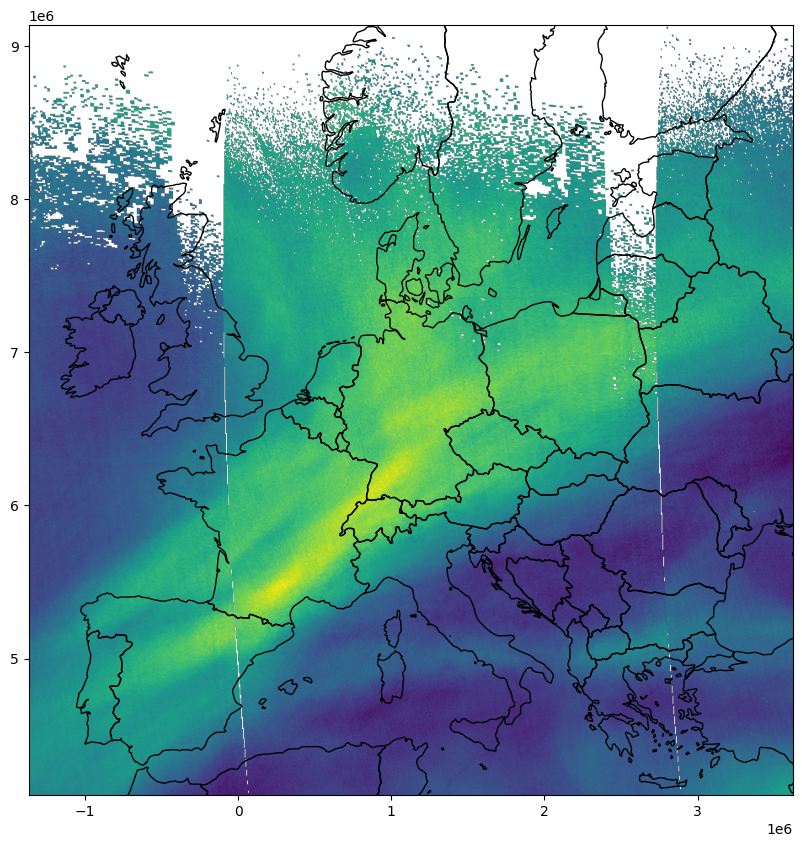

In [8]:
image_path = Path(request_raw.data_folder) / request_raw.get_filename_list()[0]

with rasterio.open(image_path) as raster:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim([bbox.min_x, bbox.max_x])
    ax.set_ylim([bbox.min_y, bbox.max_y])
    rasterio.plot.show(raster, ax=ax)
    countries.plot(ax=ax, facecolor="none", edgecolor="black")

    plt.savefig('outputs/o3_europa_20230101.png', dpi=200)

Siit võime näha, et kuigi andmed on juba mosaiigitud nii, et kogu piirdekast on täidetud, ei ole kattuvus täielik: TROPOMI mõõtmistes esineb igas ülelennus puuduvaid piksleid, sõltuvalt atmosfääritingimustest. 

# Second part: Mean over period

Proovime saada representatiivsema vaate: võtame mõõtmise väärtuste kuise keskmise, et saada terviklikum pilt.

Selleks ei pea me kogu kuu andmeid alla laadima. Selle asemel laiendame evalscripti nii, et kuine keskmine arvutatakse pilves. Nii säästame märkimisväärselt aega, sest ei pea kõiki pilte alla laadima. Vaatame uuendatud evalscripti:

Oluline muudatus on see, et mosaiikimise režiim on nüüd `ORBIT`. See annab meile ajarea kõik ülelennud, mille põhjal saab statistikat arvutada. Sisendisse lisame ka bändi `dataMask`, mis näitab, kas parameetri andmestikus on selle piksli jaoks andmed olemas. Kasutame seda, et eemaldada andmeteta omandamised arvutusest.

Funktsioonis `evaluatePixel` lisame kaks sammu: (1) filtreerime `isClear()` abil välja omandamised, millel pole andmeid, ja (2) arvutame keskmise, jagades parameetrie summa (`sum()`) selgete vaatluste arvuga.

Lõpuks tagastame arvutatud keskmise.

In [ ]:
# Mean over period

evalscript_mean_mosaic = """
//VERSION=3
function setup() {
    return {
        input: ["NO2", "dataMask"],
        output: {
            bands: 1,
            sampleType: "FLOAT32",
        },
        mosaicking: "ORBIT"
    };
}

function isClear(sample) {
    return sample.dataMask == 1;
}

function sum(array) {
    let sum = 0;
    for (let i = 0; i < array.length; i++) {
        sum += array[i].NO2;
    }
    return sum;
}

function evaluatePixel(samples) {
    const clearTs = samples.filter(isClear)
    const mean = sum(clearTs) / clearTs.length
    return [mean]
}
"""

In [ ]:
request_monthly = SentinelHubRequest(
    evalscript=evalscript_mean_mosaic,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=data_5p,
            time_interval=("2022-12-01", "2023-01-01"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox,
    resolution=(5000, 3500),
    config=config,
    data_folder="./downloads",
)

Nüüd tegime päringu terve kuu kohta. Muus osas päring sisuliselt ei muutunud.

In [ ]:
mean_data = request_monthly.get_data(save_data=True)

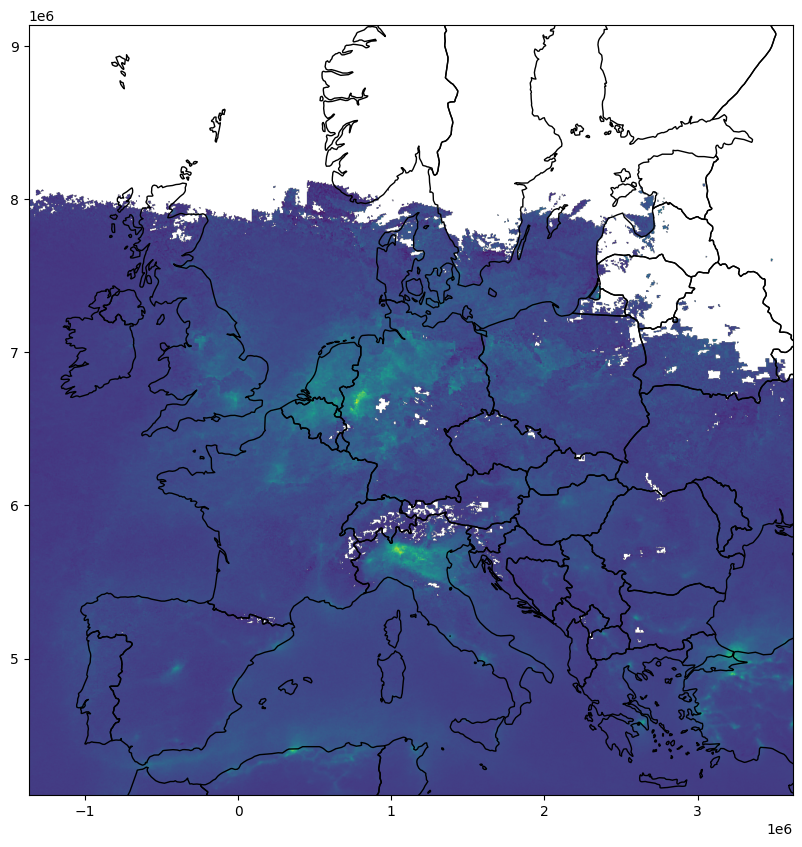

In [ ]:
image_path = Path(request_monthly.data_folder) / request_monthly.get_filename_list()[0]

with rasterio.open(image_path) as raster:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim([bbox.min_x, bbox.max_x])
    ax.set_ylim([bbox.min_y, bbox.max_y])
    rasterio.plot.show(raster, ax=ax)
    countries.plot(ax=ax, facecolor="none", edgecolor="black")

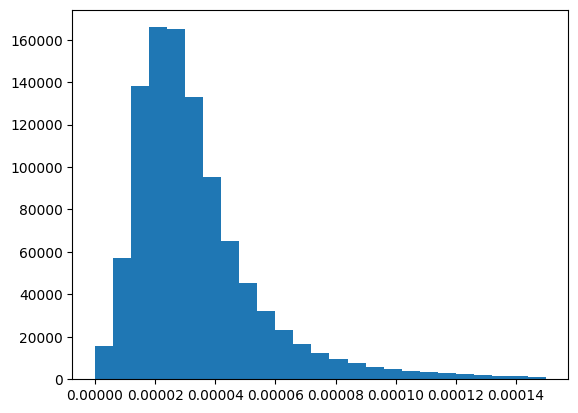

In [ ]:
plt.stairs(*np.histogram(mean_data[0], range=(0, 0.00015), bins=25), fill=True);

# Third part: concentrations by countries

Vaatame nüüd väärtuste jaotust riigiti, et näha, millistel riikidel on kuu keskmine atmosfääri parameeter suurim. 

Selleks rasterdame kõik huvipakkuva ala riigid. Nii saame välja valida kõik massiivi väärtused, mis jäävad konkreetse riigi alla.

In [44]:
countries["ID"] = countries.index

image_path = Path(request_monthly.data_folder) / request_monthly.get_filename_list()[0]
with rasterio.open(image_path) as src:
    affine = src.transform
# convert gpd Dataframe to format accepted by rasterize
geo_iter = list(countries[["geometry", "ID"]].itertuples(index=False, name=None))
# This call is converting the array into a raster with the same size as our NO2 raster
country_array = features.rasterize(
    geo_iter, transform=affine, out_shape=mean_data[0].shape, fill=-1
)

Nüüd defineerime kaks abifunktsiooni: üks kogub riigi piires kõik väärtused ja teine arvutab nende väärtuste keskmise.

In [45]:
# Now we define two helper functions which get all NO2 values in a country and another function which calcuates the mean of those values.
def get_array(country_id):
    return mean_data[0][country_array == country_id]


def get_mean(country_id):
    return np.nanmean(get_array(country_id))

Seejärel rakendame selle funktsiooni riikide aladele, et täita uus veerg `mean`, mis sisaldab riikide keskmisi NO2 väärtusi.

In [46]:
countries["mean"] = countries.apply(lambda x: get_mean(x["ID"]), axis=1)

/var/folders/wl/9wx1wpps3vs7p5l6zp3q5hz00000gn/T/ipykernel_24280/159582571.py:7: RuntimeWarning: Mean of empty slice
  return np.nanmean(get_array(country_id))


Edasi sorteerime selle keskmise alusel ja vaatame riike, mille keskmine on suurim.

In [48]:
sorted_df = countries.sort_values("mean", ascending=False)
sorted_df.head()

,ADMIN,geometry,ID,mean
20,Netherlands,"MULTIPOLYGON (((667242.94 6577267.51, 655945.7...",20,0.000108
48,Belgium,"POLYGON ((470455.301 6689943.442, 479173.878 6...",48,0.000099
40,Estonia,"MULTIPOLYGON (((3044805.494 7868837.787, 30419...",40,0.000077
36,Germany,"MULTIPOLYGON (((1060209.439 6028063.653, 10408...",36,0.000065
27,Luxembourg,"POLYGON ((680886.1 6467256.661, 679972.933 646...",27,0.000063


Viie suurima keskmisega riigi jaoks joonistame seejärel väärtuste karpdiagrammi (boxplot).

In [49]:
# get the country ids with the 5 highest mean values
n_countries = 5
country_ids = list(sorted_df["ID"][:n_countries])
country_names = list(sorted_df["ADMIN"][:n_countries])

/var/folders/wl/9wx1wpps3vs7p5l6zp3q5hz00000gn/T/ipykernel_24280/3517826048.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(country_names);


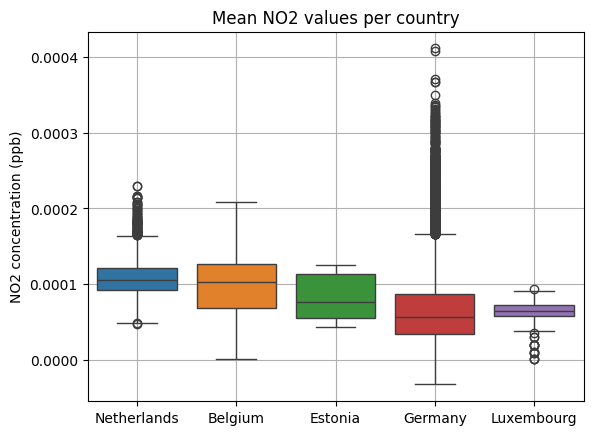

In [53]:
ax = sns.boxplot(data=[get_array(country_id) for country_id in country_ids])
ax.set_xticklabels(country_names);
ax.set_title('Mean NO2 values per country')
ax.set_ylabel('NO2 concentration (ppb)')
ax.grid()

Siit näeme, et kuigi Saksamaa keskmine on nende viie riigi seas alles neljas, esinevad seal absoluutväärtusena kõige suuremad NO2 tasemed. Samuti näeme, et Belgial ja Saksamaal on NO2 väärtuste variatsioon üsna suur: leidub nii madala kontsentratsiooniga alasid kui ka väga kõrge kontsentratsiooniga piirkondi.

# Forth part: time series over cities

Järgmisena keskendume EL-i pealinnadele. Selles täpsemas analüüsis soovime uurida ajaseriat. Selleks kasutame teist API võimalust — [Statistical API](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Statistical.html).

Ka eelmise (riikide) analüüsi puhul oleks Statistical API olnud ideaalne, kui meid poleks huvitanud ruumiline jaotus, vaid ainult kindlate geomeetriate statistika. See välistab vajaduse laadida alla suur hulk andmeid, et arvutada alade statistikat: pilves arvutatakse nt keskmine, maksimum, miinimum ja standardhälve ning tagasi saadetakse ainult need kokkuvõtlikud väärtused. 

API teine oluline võimekus on regulaarsete ajaintervallide tükeldamine (*chunking*), mida kasutame ajarea koostamiseks.

In [54]:

# load capitals
capitals = gpd.read_file("./data/eu_capitals.geojson")

Statistical API evalscript on üsna sarnane Processing API evalscriptile. Kuid Statistical API toimimiseks peame lisama veel ühe väljundi nimega `dataMask`. See annab API-le binaarse maski, mis ütleb, millised pikslid tuleb statistilisse päringusse kaasata.

Muus osas on skript võrreldes eelmise päringuga suures osas sama.

In [56]:
evalscript_stat = """
//VERSION=3
function setup() {
    return {
        input: ["NO2", "dataMask"],
        output: [{ 
          id: "default",
          bands: ["NO2"],
          sampleType: "FLOAT32" 
        },
        { 
          id: "dataMask",
          bands: 1,
        }],
        mosaicking: "ORBIT"
    };
}

function isClear(sample) {
    return sample.dataMask == 1;
}

function sum(array) {
    let sum = 0;
    for (let i = 0; i < array.length; i++) {
        sum += array[i].NO2;
    }
    return sum;
}

function evaluatePixel(samples) {
    const clearTs = samples.filter(isClear)
    const mean = sum(clearTs) / clearTs.length
    return {default: [mean], dataMask: [clearTs.length]}
}
"""

Nüüd defineerime Statistical API päringu. Selleks määrame esmalt agregatsiooni: siin paneme paika huvipakkuva ajavahemiku (vaata JUHEND.md tabelist). 

Seejärel määrame agregatsiooni intervalli, mis ütleb, mitme päeva kaupa väärtusi kokku võetakse. Kuna Sentinel‑5P korduvkülastus on väga tihe, saame valida päevase ajalise lahutuse. Sama hästi võiksime koostada ka nädala- või kuupõhise ajarea, muutes intervalli vastavalt `P1W` või `P1M`.

Pildi suurus on 1×1 pikslit, sest Sentinel‑5P pikslid on üsna suured ja pealinnade jaoks huvitab meid punktandmestik.


In [ ]:
aggregation = SentinelHubStatistical.aggregation(
    evalscript=evalscript_stat,
    time_interval=("2023-01-01", "2023-12-31"),
    aggregation_interval="P1D",
    size=(1, 1),
)

input_data = SentinelHubStatistical.input_data(
    DataCollection.SENTINEL5P.define_from("5p", service_url=config.sh_base_url)
)

requests = []

Seejärel loome ühe päringu iga pealinna kohta. Alternatiivina võiks kasutada ka [Batch Statistical API-d](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/BatchStatistical.html), mis on mõeldud paljude polügoonide statistika tõhusaks arvutamiseks.

See päringute loend laaditakse seejärel paralleelselt alla


In [59]:
for geo_shape in capitals.geometry.values:
    request = SentinelHubStatistical(
        aggregation=aggregation,
        input_data=[input_data],
        geometry=Geometry(geo_shape, crs=CRS(capitals.crs)),
        config=config,
    )
    requests.append(request)

download_requests = [request.download_list[0] for request in requests]
client = SentinelHubStatisticalDownloadClient(config=config)
pollution_stats = client.download(download_requests, max_threads=5, show_progress=True)

  0%|          | 0/27 [00:00<?, ?it/s]

See on abifunktsioon, mis teisendab Statistical API väljundi pandas-andmetabeliks.

In [60]:
def stats_to_df(stats_data):
    """Transform Statistical API response into a pandas.DataFrame"""
    df_data = []

    for single_data in stats_data["data"]:
        df_entry = {}
        is_valid_entry = True

        df_entry["interval_from"] = parse_time(single_data["interval"]["from"]).date()
        df_entry["interval_to"] = parse_time(single_data["interval"]["to"]).date()

        for output_name, output_data in single_data["outputs"].items():
            for band_name, band_values in output_data["bands"].items():
                band_stats = band_values["stats"]
                if band_stats["sampleCount"] == band_stats["noDataCount"]:
                    is_valid_entry = False
                    break

                for stat_name, value in band_stats.items():
                    col_name = f"{output_name}_{band_name}_{stat_name}"
                    if stat_name == "percentiles":
                        for perc, perc_val in value.items():
                            perc_col_name = f"{col_name}_{perc}"
                            df_entry[perc_col_name] = perc_val
                    else:
                        df_entry[col_name] = value

        if is_valid_entry:
            df_data.append(df_entry)

    return pd.DataFrame(df_data)

Siin koostame andmeraami päringu väljundi põhjal.

In [61]:
no2_dfs = [stats_to_df(polygon_stats) for polygon_stats in pollution_stats]

for df, capital in zip(no2_dfs, capitals["name"].values):
    df["name"] = capital

no2_df = pd.concat(no2_dfs)
no2_df["month"] = no2_df["interval_from"].astype("datetime64[ns]").dt.month
no2_df.to_csv("./outputs/no2_capitals_timeseries.csv")
no2_df

,interval_from,interval_to,default_NO2_min,default_NO2_max,default_NO2_mean,default_NO2_stDev,default_NO2_sampleCount,default_NO2_noDataCount,name,month
0,2023-07-03,2023-07-04,0.000044,0.000044,0.000044,0.0,1.0,0.0,Vilnius,7
1,2023-07-04,2023-07-05,0.000019,0.000019,0.000019,0.0,1.0,0.0,Vilnius,7
2,2023-07-05,2023-07-06,0.000025,0.000025,0.000025,0.0,1.0,0.0,Vilnius,7
3,2023-07-09,2023-07-10,0.000032,0.000032,0.000032,0.0,1.0,0.0,Vilnius,7
4,2023-07-12,2023-07-13,0.000057,0.000057,0.000057,0.0,1.0,0.0,Vilnius,7
...,...,...,...,...,...,...,...,...,...,...
177,2024-06-24,2024-06-25,0.000021,0.000021,0.000021,0.0,1.0,0.0,Vienna,6
178,2024-06-25,2024-06-26,0.000040,0.000040,0.000040,0.0,1.0,0.0,Vienna,6
179,2024-06-26,2024-06-27,0.000046,0.000046,0.000046,0.0,1.0,0.0,Vienna,6
180,2024-06-27,2024-06-28,0.000073,0.000073,0.000073,0.0,1.0,0.0,Vienna,6


Selle tabeliga saame nüüd analüüsi teha. Näitena vaatame mõne pealinna NO2 ajaseriat.

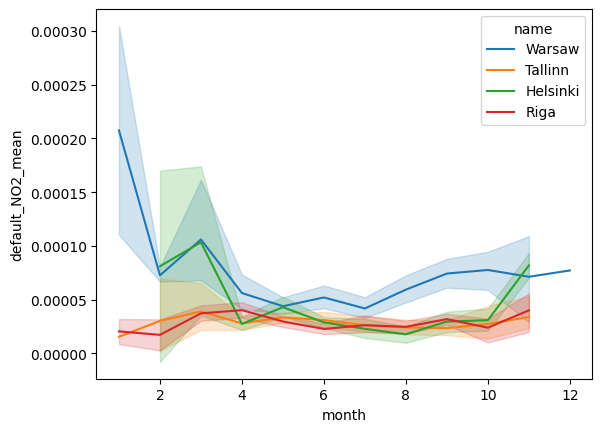

In [62]:
sel_capitals = ["Tallinn", "Riga", "Helsinki", "Warsaw"]
sns.lineplot(
    data=no2_df.loc[no2_df["name"].isin(sel_capitals)],
    x="month",
    y="default_NO2_mean",
    hue="name",
);

Kui andmed on kätte saadud, saab teha väga erinevaid analüüse. See demonstreeris Statistical API eelist: ei ole vaja alla laadida terveid kaadreid isegi siis, kui huvitab ainult ühe piksli väärtus. See teeb ligipääsu andmetele märksa tõhusamaks ja võimaldab analüüsiga kiiremini alustada.
